# Locked Staking: A Bayesian Perspective
Author: Carlos Alberto da Costa Filho, 2021

*Disclaimer (READ THIS): Nothing herein is financial advice. Cryptocurrency investments are* ***highly*** *risky, much more so than traditional investments. Risk in cryptocurrencies is not only from variations in price, but also from little or no instituticional protection. Do your own due dilligence!*

## Introduction
### Quick summary
If you don't know what crypto staking of Bayesian analysis are, you've come to the right place. Locked staking is a service whereby you provide some crypto for a certain period in exchange for an interest rate at the end of the period. If the crypto drops in the meantime, the interest gains are moot. I explore some models and Bayesian inference to estimate volatility and understand what are the risks in investing in these products.

### Longer summary


Decentralized finance (DeFi) [1, 2] offers financial products such as savings accounts, lending, borrowing, etc. in a decentralized manner, usually using crytocurrency as medium of exchange and smart contracts as a way to enforce them. Dedicated DeFi platforms have sprung up (e.g. [Compound](https://compound.finance/), [Celsius](https://celsius.network/)), and established cryptocurrency platforms have made DeFi products available to their clients (e.g. [Coinbase](https://www.coinbase.com/), [Binance](https://www.binance.com/en)).

For the passive investor, despite the risks [1], DeFi may offer an opportunity for generating interest on cryptoassets. Binance, for example, offers simple savings accounts for various cryptocurrencies, even stablecoins (word of warning: popular stablecoin USDT "Tether" organization has been found to mislead investors about the size of their fiat reserves [3]).

Another, riskier, investment is provided by "staking". The investor "stakes" some of their assets, in exchange for a promise of the pricipal plus an interest at the end of the staking period. Staked cryptoassets may also be "locked" into the contract, without the possibility of redeeming them before the maturity. Beyond the traditional risk of cryptocurrencies, locked staked products face the risk of strong devaluation before maturity without the opportunity of unloading these assets (e.g. through a stop-loss order).

In this notebook we will explore some models for pricing cryptocurrency. One will be a simple time-invariant model, and another a stochastic model using a Geometric Brownian motion model with drift as described in [4]. We will use these models to estimate the range of movement for a certain cryptoasset, which can help in deciding the risk of abrupt devaluation.

Most of the stochastic analysis in this notebook is derived from [the official PyMC3 examples](https://docs.pymc.io/notebooks/stochastic_volatility.html) and from [a blog post by Scott Rome](https://srome.github.io/Eigenvesting-IV-Predicting-Stock-And-Portfolio-Returns-With-Bayesian-Statistics/).


[1] Fabian Schär, 2021, "[Decentralized Finance: On Blockchain- and Smart Contract-Based Financial Markets](https://research.stlouisfed.org/publications/review/2021/02/05/decentralized-finance-on-blockchain-and-smart-contract-based-financial-markets
)," Federal Reserve Bank of St. Louis Review

[2] Coindesk, 2020, "[What is DeFi](https://www.coindesk.com/what-is-defi)"

[3] New York State Office of the Attorney General, 2021, "[Press Release: Attorney General James Ends Virtual Currency Trading Platform Bitfinex’s Illegal Activities in New York](https://ag.ny.gov/press-release/2021/attorney-general-james-ends-virtual-currency-trading-platform-bitfinexs-illegal
)"

[4] Matthew D. Hoffman and Andrew Gelman, 2011, "[The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](https://arxiv.org/abs/1111.4246)"



## Imports

In [1]:
%matplotlib inline
import cryptocompare as cc
import graphviz
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp

CPUS = multiprocessing.cpu_count()
# plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

print(f"{CPUS} CPUs available")

8 CPUs available


In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Mar 30 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.21.0

scipy        : 1.6.1
cryptocompare: 0.7.5
graphviz     : 0.16
numpy        : 1.20.2
pymc3        : 3.11.2
pandas       : 1.2.3
matplotlib   : 3.4.0

Watermark: 2.2.0



## Locked Staking

Before we delve into the code, let's talk about locked staking. In traditional investments, it is common to provide some money up front in exchange for an interest rate at the end of some time period. In the simplest case, you provide $P$, and after a certain time (let's say a year) the bond pays you $P + rP$. You made $rP$, on top of the principal.

Locked staking works very similarly, but they require that you provide a certain crytoasset instead of a fiat currency like dollars or euros. In this case, you put $e_i P$, and get at the end $e_f (P+rP)$. Here $e_i$ and $e_f$ are the exchange rates of fiat-to-crypto at the beginning and end of the contract.

It's clear now how the exchange rate plays an important part: if the exchange rate is 1-1 at the beginning, but loses 20% of its value by the end of maturity, you'd need your interest rate to be enormous to make any profit:

$\qquad 1 \times P < 0.8 \times (P + r P)$

$\qquad 1 < 0.8 (1 + r)$

$\qquad 0.25 < r$

You'd need a interest rate higher than 25%. Supposing the crypto is staked for a period of 30 days. This means an anualized percentage yield (APY) of 1400%! Clearly, understanding the exchange rate is key in deciding if it is a good deal.

## Obtaining Data

<i>"Without data, you're just another person with an opinion", W. Edwards Deming</i>

The first part is obtaining the historical prices of the cryptocurrency we are looking to stake. The following function obtains a Pandas DataFrame containing open, high, low, close and volume information from [CryptoCompare](https://www.cryptocompare.com/).

In [3]:
class OHLCVNotFoundError(Exception):
    def __init__(self, message):
        self.message = message

def find_first_nonzero(response):
    """
    Parameters
    ----------
        response : iterable
            Every item is a dictionary which must contain at least keys:
            'open','close', 'high', 'low'.

    Returns
    -------
        int
            First index where the entry is not zero. If none found, return -1.
    """
    first_nonzero = -1
    for i, datapoint in enumerate(response):
        if (
            datapoint["open"] != 0
            or datapoint["close"] != 0
            or datapoint["high"] != 0
            or datapoint["low"] != 0
        ):
            first_nonzero = i
            break  # Find first nonzero point
    return first_nonzero


def get_ohlcv(coin, currency, limit=None):
    """
    Parameters
    ----------
        coin : str
        currency: str
            Specifies the currency you would like the `coin` priced at.
        limit : int, optional
            Limits the response to `limit` entries.

    Returns
    -------
        DataFrame
            Contains columns 'high', 'low', 'open', 'close', 'volume'.
            'Volume' is priced in the `coin`.

    Raises
    ------
        OHLCVNotFoundError
            If all entries are zero, raises OHLCVNotFoundError
    """
    if limit is None:
        response = cc.get_historical_price_day(coin, currency)
    else:
        response = cc.get_historical_price_day(coin, currency, limit=limit)
    # `response` may contain many identically zero entries. We need
    #  to find the first nonzero so as to drop all the useless info
    first_nonzero = find_first_nonzero(response)
    if first_nonzero == -1:
        message = f"No nonzero values found for pair {coin}/{currency}"
        raise OHLCVNotFoundError(message)
    df = pd.DataFrame(response[first_nonzero:])
    df = df.rename({"volumefrom": "volume"}, axis=1)
    df.index = pd.to_datetime(df.time, unit="s")
    df.index.name = "Date"
    return df[["high", "low", "open", "close", "volume"]].asfreq("D")

We will use the above function to obtain data for Chromia (CHR) priced in Euros.

In [4]:
coin = 'CHR'
currency = 'EUR'
ohlcv = get_ohlcv(coin, currency)
ohlcv.tail(2)

,high,low,open,close,volume
Date,,,,,
2021-03-29,0.3726,0.3261,0.3229,0.3452,32542482.40
2021-03-30,0.4085,0.3244,0.3452,0.3822,50963754.87


We will use as prices the OHLC average: $(O + H + L + C)/4$

In [5]:
price = ohlcv[['high', 'low', 'open', 'close']].mean(axis=1)
price.name = f'{coin}-{currency}'

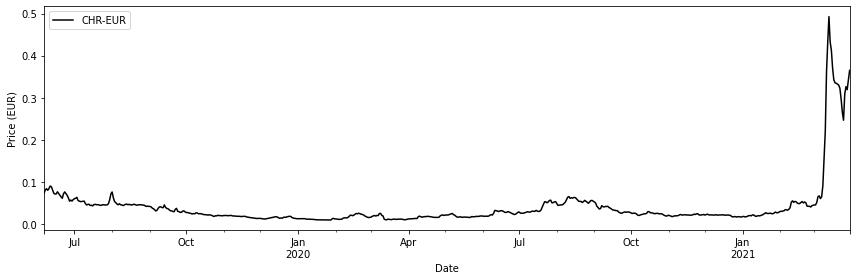

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', ax=ax)
ax.set(ylabel=f'Price ({currency})')
ax.legend()
fig.tight_layout()

# Descriptive Statistics: What is the Data Telling Us?

<i>"A statistician confidently tried to cross a river that was 1 meter deep on average. He drowned."</i>

Before we start our fancy Bayesian modeling, let's take a look at some descriptive statistics. Descriptive statistics tell us useful summaries of the data, which we can use to understand our data. But like the quote suggests, they can also mislead us if we don't look closely enough.

Commonly used summaries include average (ie. mean), median (i.e. 50ᵗʰ percentile) and stardard deviation. Average returns and volatility in finance are usually measured in terms of log variations in price. We calculate the log of the daily returns as defined by

$\qquad r_t = \log(S_{t}/S_{t-1}) = \log(S_{t}) - \log(S_{t-1})$

where $S_t$ and $r_t$ are the price and the log-return at time $t$, respectively.

In [7]:
def get_logreturns(price: pd.DataFrame):
    return np.log(price).diff().dropna()

In [8]:
logreturns = get_logreturns(price)
logreturns.describe()

count    663.000000
mean       0.002411
std        0.073184
min       -0.495261
25%       -0.035240
50%       -0.002583
75%        0.032978
max        0.526118
Name: CHR-EUR, dtype: float64

Our statistics show that our average daily log-returns are slightly above zero at around 0.2%, and our volatility is around 7%. Another way to obtain this information is to "fit" a normal distribution on the data. That is, to obtain the normal distribution which best matches our histogram.

In this same way, we can fit other distributions such as the [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which is known to better model stock-market returns (see e.g. [5]).

[5] Amado Peiró, 1994, [The distribution of stock returns: international evidence](https://www.tandfonline.com/doi/abs/10.1080/758518675), Applied Financial Economics, 4:6, 431-439

In [9]:
# Finds the best parameters matching our data 
mu, std = sp.stats.norm.fit(logreturns)
nu, loc, scale = sp.stats.t.fit(logreturns)

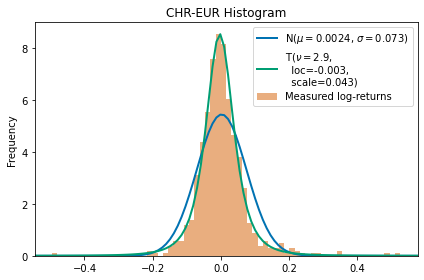

In [10]:
fig, ax = plt.subplots()
logreturns.plot.hist(density=True, bins='fd', color='C2', alpha=0.5, label='Measured log-returns', ax=ax)

xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
pdf_n = sp.stats.norm.pdf(x, mu, std)
pdf_t = sp.stats.t.pdf(x, nu, loc, scale)
ax.plot(x, pdf_n, lw=2, label=rf"N($\mu={mu:.2g}$, $\sigma={std:.2g}$)")
ax.plot(x, pdf_t, lw=2, label=(rf'T($\nu={nu:.2g}$, '
                               f'\n  loc={loc:.2g},\n  scale={scale:.2g})'))

ax.set(xlim=[xmin, xmax], title=f"{logreturns.name} Histogram")
ax.legend()
fig.tight_layout()

Clearly, the Student's t-distribution is a much better fit. If we had assumed normal returns, we would have made three mistakes: 1) very small returns would be understimated, 2) mid-range returns would be more probable than in reality, and 3) very large (in magnitude) returns would be understimated. In fact, it's possible even the Student's t-distribution understimates whose when compared to the real data. 

Now let's discuss the Student's t-distribution parameters. The loc parameter specifies where it is centered (similar to the mean of the normal distribution). The scale parameter scales the value of the peak (somewhat similar to the mean for the normal distribution). The $\nu$ parameter, also known as degrees of freedom, is always nonzero. The smaller it is, the fatter the tail of the distribution (that is, the more probably very large magnitude returns are).

## Inferential statistics: Simulating Returns

<i>\"Past performance is not indicative of future results"</i>

Now that we have a decent description of our data, we can leverage it in a very rudimentary way to understand price movements. Since we know how log-returns behave, we can generate a bunch of log-returns and move our price accordingly.

An important aspect to keep in mind here is the concept of "cross-validation". We want to make predictions about the future, which we do not have data for. But in that case, there would no way to validate our model, that is, to make sure that it is consistent with reality. One solution to this is to withhold some data when building the model, which we can later use to verify if it matches with the simulated data. This is the common "test-train" split in machine learning.

We will do that by pretending we don't have the last 10 days of trading (which we hope to predict).

In [11]:
n_days = 10
nu_train, loc_train, scale_train, = sp.stats.t.fit(logreturns[:-n_days])

Now we use information to simulate many returns:

In [12]:
n_sims = 500

np.random.seed(seed=9)
logrets_t = sp.stats.t(nu_train, loc_train, scale_train).rvs(size=(n_sims, n_days))

We won't plot this data, but its histogram should closely match the real prices (for the same time period). The difference is that our real log-returns seem to have some outliers which are not well-represented by the Student's t-distribution.

Now, we will use this same information to "convert" them to prices.

In [13]:
def predict_price(logreturns, starting_price=1.):
    return np.maximum(np.cumprod(np.exp(logreturns), axis=-1) * starting_price, 0.)

In [14]:
starting_price = price[-n_days-1] # Last day in our "training" dataset
prices_t_arr = predict_price(logrets_t, starting_price=starting_price) # predict prices
prices_t_arr = np.insert(prices_t_arr, 0, starting_price, axis=-1) # insert starting price
simulated_index = price.index[-n_days-1:]

Let's take a quick look at this dataset.

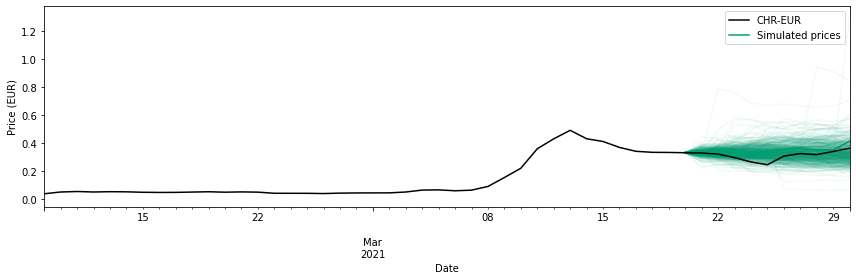

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', ax=ax)
ax.plot(simulated_index, prices_t_arr[0,:], color="C1", zorder=-2, label='Simulated prices')
ax.plot(simulated_index, prices_t_arr.T, color='C1', alpha=0.05, zorder=-1)
ax.set(xlim=[price.index[-5*n_days], price.index[-1]],
       ylabel=f'Price ({currency})')
ax.legend()
fig.tight_layout()

Not too bad. The actualized price (which we did not include in the model) is well within the range of predictions. One thing we notice, however, is that our y-scale is really large. This is not merely a plotting annoyance: it tells us that there are a few, but nonzero realizations where the price moons or tanks. The exact likelihood of these events can be better visualized with quartiles. These are the ranges in which the price will likely be bound according to your model.

We choose two cones, the first from the 5ᵗʰ percentile to 95ᵗʰ percentile (the price will be inside this cone with 90% confidence), and the second from the 25ᵗʰ to the 75ᵗʰ percentile (the price will be inside this cone with 50% confidence). These are called "Bayesian cones".

In [16]:
percentiles_t = {p: pd.Series(np.percentile(prices_t_arr, p, axis=0), index=simulated_index)
                 for p in [5, 25, 50, 75, 95]}

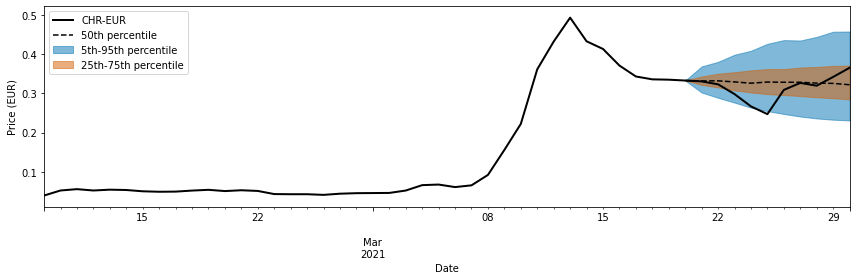

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', linewidth=2, ax=ax, label=f'{price.name}')
ax.fill_between(percentiles_t[5].index, percentiles_t[5], y2=percentiles_t[95], color='C0',
                alpha=0.5, interpolate=True, label='5th-95th percentile')
ax.fill_between(percentiles_t[25].index, percentiles_t[25], y2=percentiles_t[75], color='C2',
                alpha=0.5, interpolate=True, label='25th-75th percentile')
percentiles_t[50].plot(color='k', linestyle='--', ax=ax, label='50th percentile')
ax.set(xlim=[price.index[-5*n_days], price.index[-1]], ylim=[price.min(), (1.+price.std())*price.max()],
       ylabel=f'Price ({currency})')
ax.legend(loc=2)
fig.tight_layout()

Not terrible for a very simple model! Here I must admit to some malarkey: I specifically chose the number of days used for the prediction so as to make the above graph look pretty. If I had started my price prediction 20 days earlier, our most optimistic predictions would *never* have predicted the huge surge starting on the March 8. This is not a problem in the modeling per se, rather, a price surge like that had never been seen in the data.

## Bayesian Modeling: Interpreting What the Data is Telling Us

<i>\"When one admits that nothing is certain one must, I think, also add that some things are more nearly certain than others", Bertrand Russell</i>

Let's recap what we have done so far. First we decided to investigate log-returns (try plotting returns instead of log-returns to see why). Then we inspected their distribution and came up with a reasonable shape for it (Student's t). Finally we used to data to obtain parameters which were in some sense those which "best fit" our empirical data. We had one specific parameter for $\nu$ (degrees of freedom), one for "loc" and one for "scale".

In Bayesian modeling, we will work a bit differently. We will decide a *model*, which incorporates random variables, not simply deterministic relations. This model will rely on parameters which, like the we did above, we will need to estimate. However, instead of looking for **one** value for each parameter, we want to determine the probability of all values of a specific parameter. Let's use $\nu$ as an example. Sure, the "best fit" was $\nu=2.9$, but would it be so crazy to think that it could be $\nu=3.0$, for example if we added more data? Certainly not! What about $\nu = 10$? Maybe a little bit more unlikely, we'd posit. How unlikely?

The exact probability of the values of $\nu$ (and other parameters) is exactly what a Bayesian analysis gives us. And this adds a lot more information about our model. Instead of obtaining **one** value for $\nu$, for example, we will obtain an entire probability distribution of $\nu$, informed by the data of course. The distribution after we have informed it with data is called the posterior. A very wide posterior can mean that the model is poor (does not match our data), or that the parameter cannot be inferred from the data. How would be know this from a simple fitting? Unless we assume a particular shape for the posterior, we can't!

The last piece which is missing for our Bayesian modeling is choosing priors for our parameters. Priors, as their name implies, encode whatever information we have *prior* to any inference, that is, plugging in data. Priors need not be perfect, and in infinite time, they don't matter (but in practice they kind of do, so we'll be smart and choose good priors). For example, if you know a parameter can't be negative, it makes no sense trying creating a model which can test negative values. Here, we will use general priors like normal for parameters which can be positive or negative (like mean) and exponential or half-Cauchy for variables which must be positive (like degrees of freedom).

In [18]:
def get_student_t_model(data):
    with pm.Model() as model:
        mean = pm.Normal('mean', mu=0, sd=.05, testval=data.mean())
        sigma = pm.HalfCauchy('volatility', beta=1, testval=data.std())
        nu = pm.Exponential('nu', lam=1. / 10., testval=3.)

        logreturns = pm.StudentT('logreturns', nu=nu, mu=mean, sd=sigma, observed=data)
    return model

A quick note on the choices of parametrization. This model is based on the one used by the defunct Quantopian in their PyFolio library simply because they offer sensible defaults. $\mu$ is chosen to have a prior centered at 0, with a standard deviation of 5%. `testval` is a starting value, which we will set to start at the average obtained from the data. This is simply to improve the convergence of the model, and doesn't impact the prior. We will use a similar trick for volatility $\sigma$, which we model as a half-Cauchy. Finally, the degrees of freedom will start at 3 (very similar to what we obtained from the fitting employed in the previous section.

In [19]:
model_t = get_student_t_model(logreturns[:-n_days])

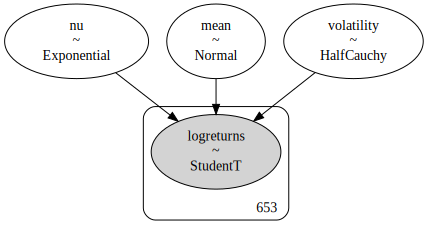

In [20]:
pm.model_to_graphviz(model=model_t)

## Bayesian Inference

Now that we have a model, we need to feed it some information. For example, if you had a biased coin, you could model it as 

* Coin toss is distributed as a binomial distribution with $q =$ bias
* The prior on the bias could uniform between $[0, 1]$ if you have no reason to suspect any bias is more likely than the other. Or, if you suspect the coin is fair, you could use a trucanted normal centered at $0.5$.

So if you measured only heads (represented by 1), you'd expect your coin toss to be biased towards 1. In this case, after feeding all the data, we should change our idea on what the bias is. It is not normally or uniformly distributed, rather, it is very likely concentrated around 1.

The same thing happens with our model for log-returns. While we created priors for our variables, only after feeding it data, will we be really able to know how they are distributed. In PyMC3 this process is very simple. It works by sampling the posterior distribution as follows.

In [21]:
with model_t:
    trace_t = pm.sample(2000, tune=2000, chains=4, cores=CPUS, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [nu, volatility, mean]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [22]:
fname = ".pymc_trace_t.trace"
pm.save_trace(trace_t, fname, overwrite=True)
print(f'trace_t stored at "{fname}"')

# Read with
# with model_t:
#     pm.load_trace(fname)

trace_t stored at ".pymc_trace_t.trace"


Now we visualize our results. And we will remember our best-fit values obtained in the previous section and see where they fall.

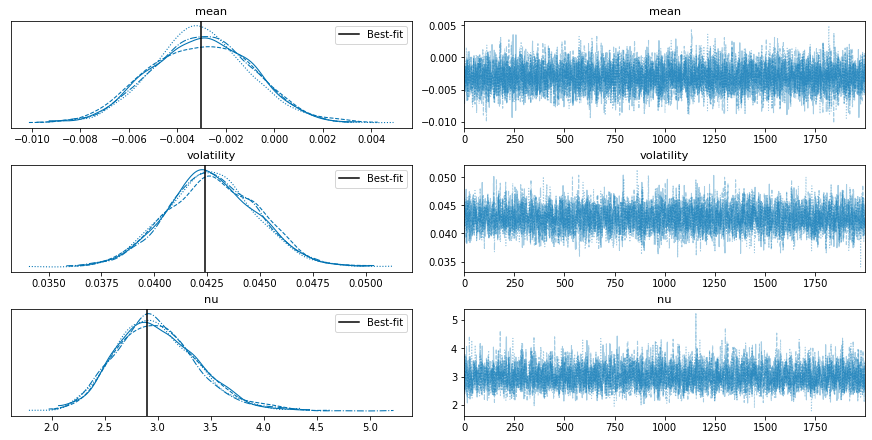

In [23]:
with model_t:
    axes = pm.plot_trace(trace_t, var_names=['mean', 'volatility', 'nu'])
    
    axes[0][0].axvline(loc_train, color='k', label='Best-fit')
    axes[1][0].axvline(scale_train, color='k', label='Best-fit')
    axes[2][0].axvline(nu_train, color='k', label='Best-fit')
    for ax in axes[:,0]:
        ax.legend()

What do these graphs tell us? On the left: we ran 4 chains so we have 4 independent posterior estimates (solid/dashed/dotted/dot-dashed lines). Remember we started with priors (like normal for $\mu$) and now we have non-normal estimates for these parameters (they may look normal, but they are data-derived). On the right: it shows the sampling of the chains; in general they should spend most of their time sampling more probable regions.

This figure illustrates what we mean when we say we obtain an entire probability distribution instead of a single value. The "best-fit" value is indeed the maximum a posteriori (MAP), that is, the value which maximizes the posterior distribution. But it is **one** value, which obviously cannot capture the entirety of the distribution.

### Predicting Prices from Bayesian Inference

Now we will take some samples from the posterior. This means that we are going to generate several returns for every time sample we have in our model. We did this before by simply sampling from our "best-fit" model. In the Bayesian modeling, we need to first sample from the posterior of the parameters of the Student's t, and only then sample from the Student's t. PyMC3 does that all at once with:

In [24]:
with model_t:
    posterior_predictive_t = pm.sample_posterior_predictive(trace_t, samples=n_sims)

/home/cdacosta/.local/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Oops. Seems like PyMC3 did not like our number of simulations. It is telling us that we may not be sampling our posterior enough times. We know our chains look fairly similar, and the posteriors all look well behaved. So we will ignore this warning. Otherwise we could remove the `samples` parameter and PyMC3 should choose sufficient samples to represent the posterior.

In [25]:
# We have sample `n_sims` values for each day in our model
posterior_predictive_t['logreturns'].shape

(500, 653)

In [26]:
# Compared to the "best-fit" which we generated only for the last `n_days`
logrets_t.shape

(500, 10)

At this point all we must do is choose which days we would like to use for our prediction. Our model is time-independent so it doesn't matter exactly "days" are chosen. We will choose the last `n_days` samples for simplicity. We will also encapsulate many of the previous code into one function to compute the percentiles.

In [27]:
def get_percentiles(simulations, starting_price, index):
    prices_t_arr = predict_price(simulations, starting_price=starting_price) # predict prices
    prices_t_arr = np.insert(prices_t_arr, 0, starting_price, axis=-1) # insert starting price
    
    return {p: pd.Series(np.percentile(prices_t_arr, p, axis=0), index=index)
            for p in [5, 25, 50, 75, 95]}    

In [28]:
perc_bayes_t = get_percentiles(posterior_predictive_t['logreturns'][:, -n_days:], starting_price, simulated_index)

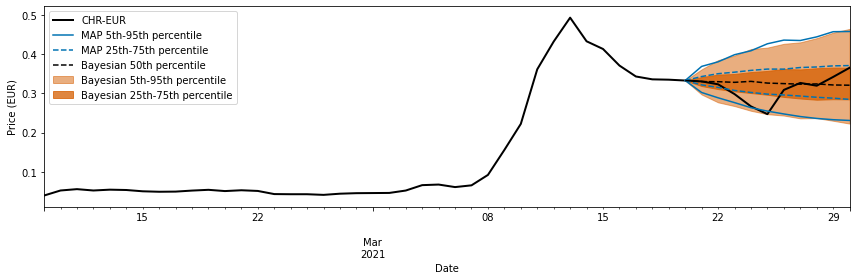

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', linewidth=2, ax=ax, label=f'{price.name}')
ax.plot(percentiles_t[5], color='C0', label='MAP 5th-95th percentile')
ax.plot(percentiles_t[95], color='C0')
ax.plot(percentiles_t[25], '--', color='C0', label='MAP 25th-75th percentile')
ax.plot(percentiles_t[75], '--', color='C0')
ax.fill_between(perc_bayes_t[5].index, perc_bayes_t[5], y2=perc_bayes_t[95], color='C2',
                alpha=0.5, interpolate=True, label='Bayesian 5th-95th percentile')
ax.fill_between(perc_bayes_t[25].index, perc_bayes_t[25], y2=perc_bayes_t[75], color='C2',
                alpha=0.75, interpolate=True, label='Bayesian 25th-75th percentile')

perc_bayes_t[50].plot(color='k', linestyle='--', ax=ax, label='Bayesian 50th percentile')
ax.set(xlim=[price.index[-5*n_days], price.index[-1]], ylim=[price.min(), (1.+price.std())*price.max()],
       ylabel=f'Price ({currency})')
ax.legend(loc=2)
fig.tight_layout()

Remember that the returns are very closely approximated by a Student's t-distribution. In addition, the percentiles are in essence a summary of the posterior. With these two observations, it stands to reason that the best-fit MAP percentiles are very similar to those obtained by the Bayesian inference. But they are not the same: we allow our model to sample from other, slighly less probably Student's t-distributions which may be slightly fatter or thinner. In this case, we can see that the MAP estimate slightly overestimates positive returns, and slightly underestimates negative returns. Dangerous!

## Stochastic Model: Ramping Up Complexity

<i>"Forecasts are difficult to make—particularly those about the future", Burton Malkiel</i>

A common way of modeling stock prices (as used in the Black-Scholes-Merton model for pricing options) is to assume that the [log-returns follow a "random walk"](https://en.wikipedia.org/wiki/Geometric_Brownian_motion). Mathematically, you may write this as:

$\qquad\mathrm{d}S_t = μ S_t\,\mathrm{d}t + σ S_t\,\mathrm{d}W_t$

Before we get on what everything means, let's rewrite it as

$\qquad\mathrm{d} \ln(S_t) = \mathrm{d}S_t /S_t  =  μ\,\mathrm{d}t + σ\,\mathrm{d}W_t$

It says that at any point in time, the variation of the log of price, $\mathrm{d} \ln(S_t)$, is given by a time-independent (but still random) return $μ$ and a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process), $W_t$, with some volatility $σ$. The exact meaning of this time-dependent process is does not matter much here, it only matters that we can model it with PyMC3. Finally, we will suppose that the average returns $\mu$, will be summed with the Wiener process as a Student's t-distribution as we did above.

An intuitive way to look at this, is to suppose that our Brownian motion $W_t$ was time-independent and normally distributed. This would yield:

$\qquad\mathrm{d} \ln(S_t) \sim μ\,\mathrm{d}t + σN(0, 1)\,\mathrm{d}t$

$\qquad\mathrm{d} \ln(S_t) \sim N(μ, σ)\,\mathrm{d}t$

$\qquad \ln(S_t) \sim N(μ, σ)$

That is, that our log-returns are normally distributed. Of course, we know this is not the best model, instead we choose the Student's t distribution for log-returns. So our Brownian motion must feed into a Student's t. Let's put the model together.

In [30]:
def get_stochastic_model(data):
    with pm.Model() as model:
        # Average return
        mu = pm.Normal('mu', 0.01, sigma=5)

        # Average volatility
        sigma = pm.Exponential('sigma', 1. / .02, testval=.1) 

        # Time-dependent volatility
        log_vol = pm.GaussianRandomWalk('log_vol', sigma**-2, shape=len(data))
        lam = pm.Deterministic('lam', pm.math.exp(-2 * log_vol)) # Simple way of parametrizing Student's t
        volatility = pm.Deterministic('volatility', pm.math.exp(log_vol))        

        # Log-returns
        nu = pm.Exponential('nu', 1. / 10, testval=5.) # Degrees of freedom
        logreturns = pm.StudentT('logreturns', nu=nu, lam=lam, mu=mu, observed=data)

    return model

In [31]:
model_s = get_stochastic_model(logreturns[:-n_days])

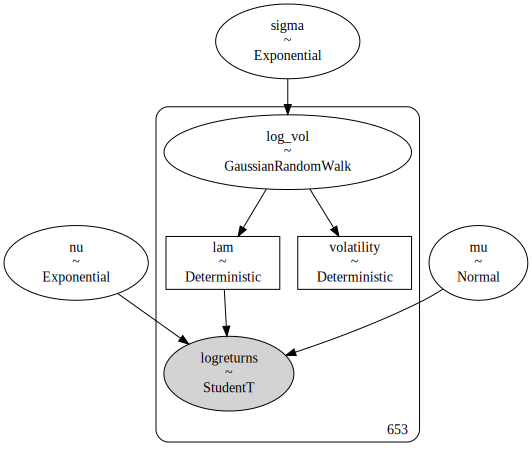

In [32]:
pm.model_to_graphviz(model_s)

In [33]:
with model_s:
    trace_s = pm.sample(4000, tune=2000, chains=4, cores=CPUS, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [nu, log_vol, sigma, mu]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 250 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
fname = ".pymc_trace_s.trace"
pm.save_trace(trace_s, fname, overwrite=True)
print(f'trace_s stored at "{fname}"')

# Read with
# with trace_s:
#     pm.load_trace(fname)

trace_s stored at ".pymc_trace_s.trace"


We will visualize our scalar variables $\mu$, $\sigma$ and $\nu$. We will plot the time-dependent volatility in a different format.

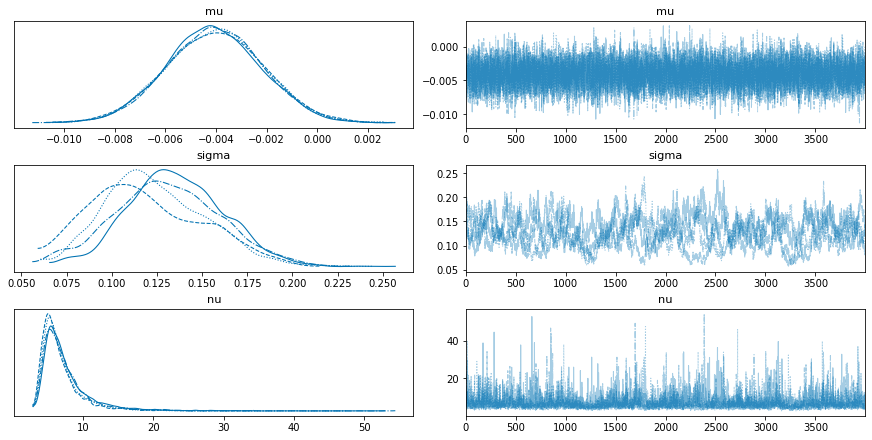

In [35]:
with model_s:
    axes = pm.plot_trace(trace_s, var_names=['mu', 'sigma', 'nu'])

On the right: our chains for $\mu$ look pretty good. For $\sigma$ they look a little funky, as well as for $\nu$. But overall, on the right, we can see that they mostly converged to the same values.

Now we will take some samples from the posterior like we did before. We will compare this with our measured returns to see if they match. In this case, since our model is time-dependent, we will expect to see some structure in time.

In [36]:
with model_s:
    posterior_predictive_s = pm.sample_posterior_predictive(trace_s)

In [37]:
pred_returns_s = pd.DataFrame(posterior_predictive_s['logreturns'].T, index=logreturns.index[:-n_days],
                                columns=[f'Sample {i}' for i in range(posterior_predictive_s['logreturns'].shape[0])])
pred_returns_s.loc[:,::1000].describe()

,Sample 0,Sample 1000,Sample 2000,Sample 3000,Sample 4000,Sample 5000,Sample 6000,Sample 7000,Sample 8000,Sample 9000,Sample 10000,Sample 11000,Sample 12000,Sample 13000,Sample 14000,Sample 15000
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,-0.002895,-0.007846,-0.007234,-0.007198,-0.007311,-0.006607,0.000647,-0.003296,-0.003512,-0.005104,0.001288,-0.006470,-0.001371,-0.007227,-0.005306,-0.003547
std,0.064817,0.065501,0.060765,0.066822,0.074561,0.063390,0.067022,0.065867,0.081276,0.072895,0.064283,0.071227,0.070379,0.074404,0.083087,0.072789
min,-0.464639,-0.260693,-0.258990,-0.369217,-0.449406,-0.313626,-0.390598,-0.371773,-0.479933,-0.617043,-0.303892,-0.509575,-0.400391,-0.627651,-0.717977,-0.635736
25%,-0.034627,-0.037932,-0.040885,-0.035002,-0.043160,-0.039108,-0.031082,-0.036151,-0.042056,-0.039039,-0.030066,-0.035742,-0.034616,-0.036417,-0.040078,-0.034500
50%,-0.003141,-0.009457,-0.004651,-0.004440,-0.007419,-0.008954,0.000947,-0.002497,-0.004028,-0.003728,0.000888,-0.000302,-0.001171,-0.006048,-0.005101,-0.002298
75%,0.030518,0.022808,0.024179,0.024947,0.033284,0.025895,0.034380,0.028409,0.026993,0.027954,0.031524,0.025279,0.032395,0.025824,0.025372,0.029455
max,0.360585,0.678904,0.357332,0.406667,0.318643,0.287473,0.533481,0.425547,0.763051,0.408461,0.413947,0.424259,0.381289,0.491105,0.737827,0.392278


And now compare it with the real returns:

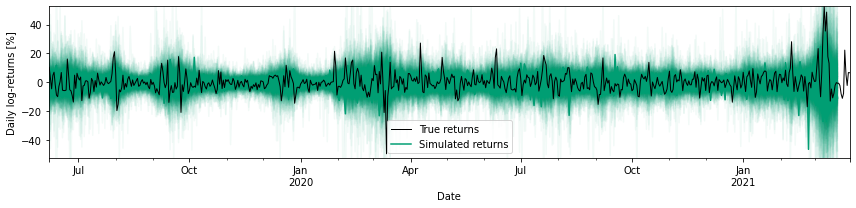

In [38]:
fig, ax = plt.subplots(figsize=(12, 3))
(100*logreturns).plot(ax=ax, lw=1, color="k", label='True returns')
ax.plot(100*pred_returns_s.iloc[:,0], color="C1", zorder=-2, label='Simulated returns')
ax.plot(100*pred_returns_s.loc[:,::50], color="C1", alpha=0.05, zorder=-1)

clip = logreturns.abs().values.max()
ax.set(ylabel='Daily log-returns [%]', ylim=100*np.array([-1,1]) * clip)
ax.legend()
fig.tight_layout()

We can also have a look at the price volatility.

In [39]:
trace_volatility = pd.DataFrame(trace_s["volatility"].T, index=logreturns.index[:-n_days],
                                columns=[f'Sample {i}' for i in range(trace_s["volatility"].shape[0])])
trace_volatility.loc[:,::1000].describe()

,Sample 0,Sample 1000,Sample 2000,Sample 3000,Sample 4000,Sample 5000,Sample 6000,Sample 7000,Sample 8000,Sample 9000,Sample 10000,Sample 11000,Sample 12000,Sample 13000,Sample 14000,Sample 15000
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,0.051158,0.047368,0.044849,0.050465,0.057788,0.053204,0.049803,0.050989,0.051748,0.055457,0.052212,0.049393,0.054657,0.047238,0.053521,0.051678
std,0.025746,0.019486,0.018308,0.025444,0.031557,0.023849,0.022198,0.023152,0.028969,0.027487,0.025310,0.027967,0.026560,0.020537,0.027029,0.023341
min,0.013650,0.016536,0.014408,0.016684,0.013363,0.016060,0.013882,0.019235,0.012366,0.015372,0.017915,0.014362,0.011187,0.016985,0.016429,0.014937
25%,0.036479,0.035434,0.032810,0.035370,0.037507,0.038489,0.035469,0.037740,0.033077,0.038601,0.035133,0.032099,0.036716,0.033918,0.038925,0.037957
50%,0.045496,0.044544,0.041997,0.045673,0.054156,0.048908,0.045008,0.047092,0.044554,0.050369,0.047789,0.043643,0.049381,0.043577,0.048487,0.047685
75%,0.057921,0.055366,0.053584,0.057529,0.068764,0.063453,0.059270,0.056485,0.060489,0.066582,0.063539,0.059699,0.066608,0.056237,0.061424,0.059904
max,0.209420,0.187144,0.144749,0.227455,0.262594,0.179319,0.169710,0.193499,0.217517,0.231709,0.195970,0.246881,0.182730,0.148270,0.228458,0.186771


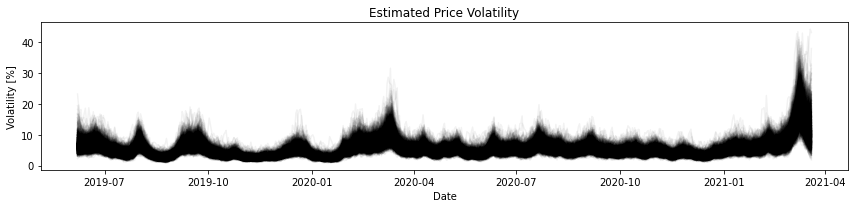

In [40]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(100*trace_volatility.loc[:,::10], color="k", alpha=0.05, zorder=-10)
ax.set( xlabel="Date", ylabel='Volatility [%]', title="Estimated Price Volatility")
fig.tight_layout()

### Price Prediction Revisited

Now that we have a calibrated model for estimating daily returns, we can predict prices.

In [41]:
perc_bayes_s = get_percentiles(posterior_predictive_s['logreturns'][:, -n_days:], starting_price, simulated_index)

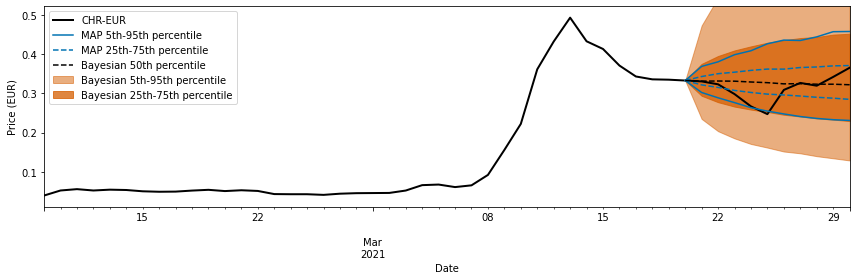

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', linewidth=2, ax=ax, label=f'{price.name}')
ax.plot(percentiles_t[5], color='C0', label='MAP 5th-95th percentile')
ax.plot(percentiles_t[95], color='C0')
ax.plot(percentiles_t[25], '--', color='C0', label='MAP 25th-75th percentile')
ax.plot(percentiles_t[75], '--', color='C0')
ax.fill_between(perc_bayes_s[5].index, perc_bayes_s[5], y2=perc_bayes_s[95], color='C2',
                alpha=0.5, interpolate=True, label='Bayesian 5th-95th percentile')
ax.fill_between(perc_bayes_s[25].index, perc_bayes_s[25], y2=perc_bayes_s[75], color='C2',
                alpha=0.75, interpolate=True, label='Bayesian 25th-75th percentile')

perc_bayes_s[50].plot(color='k', linestyle='--', ax=ax, label='Bayesian 50th percentile')
ax.set(xlim=[price.index[-5*n_days], price.index[-1]], ylim=[price.min(), (1.+price.std())*price.max()],
       ylabel=f'Price ({currency})')
ax.legend(loc=2)
fig.tight_layout()

Oh wow! Our stochastic cone is huge! What's going on here? If we recall our volatility graph, we see that in this time period, we have a huge spike in volatility. Indeed this time period shows the highest average volatility of all time! So it makes sense that our Bayesian model is reflecting that. Why doesnt't the simple model capture that? Well, because it uses a time-independent volatility, which "averages" the volatility of the entire history of the model. We fed it so much that that we lost some of the nuance of the underlying problem: the fact that the fundamentals (or rather, market outlook of these assets) change over time.

## Locked Staking: Gain or Gamble?

We started this discussion with locked staking and how the exchange rate affects it. Now that we have spent some time talking about different models, we can go back to analyzing our main problem. But our discussion was important because it must be clear that choices have consequences: a simple model may give innacurate results, but a super complex model may lose capacity to generalize. Some balance must be struck between them, and we must be very careful on how we use our data.

Let's get back to coding, but this time let's try to predict the future. We start by rerunning our posterior with all data.

In [43]:
model_s_all = get_stochastic_model(logreturns)

In [44]:
with model_s_all:
    trace_s_all = pm.sample(4000, tune=2000, chains=4, cores=CPUS, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [nu, log_vol, sigma, mu]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 300 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [45]:
with model_s_all:
    posterior_predictive_s_all = pm.sample_posterior_predictive(trace_s_all)

In [46]:
pred_returns_s_all = pd.DataFrame(posterior_predictive_s_all['logreturns'].T, index=logreturns.index,
                                  columns=[f'Sample {i}'
                                           for i in range(posterior_predictive_s_all['logreturns'].shape[0])])

To estimate the returns for the next `n_days`, we will use the previous last `n_days`. This is a design choice, and we could extend (or shorten) our range.

In [47]:
index_future = pd.date_range(start=price.index[-1], periods=n_days+1, freq='D')
logrets_for_pred = posterior_predictive_s_all['logreturns'][:,-n_days:]
perc_bayes_s_all = get_percentiles(logrets_for_pred, starting_price=price[-1], index=index_future)

The last bit of information we need to make a decision on locked staking is the interest rate. I will choose the very large interest rate of 50% to prove our point. We will apply this interest rate to the 50ᵗʰ percentile.

In [48]:
interest_rate = 50.0

fixed_logrets = np.percentile(logrets_for_pred, 50, axis=0) + np.log((1. + interest_rate/100.)**(1./365.))
fixed_prices = predict_price(fixed_logrets, starting_price=price[-1])
fixed_perc50 = pd.Series([price[-1]] + list(fixed_prices), index=index_future)

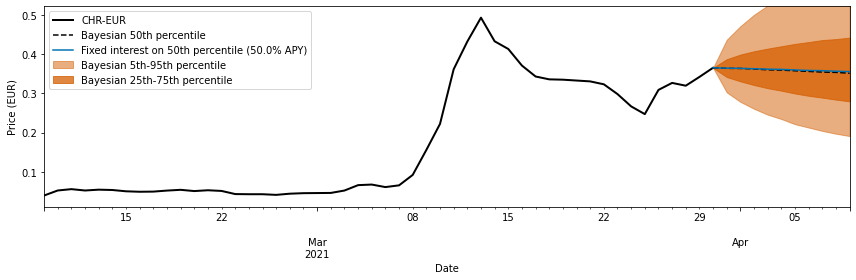

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
price.plot(color='k', linewidth=2, ax=ax, label=f'{price.name}')

ax.fill_between(perc_bayes_s_all[5].index, perc_bayes_s_all[5], y2=perc_bayes_s_all[95], color='C2',
                alpha=0.5, interpolate=True, label='Bayesian 5th-95th percentile')
ax.fill_between(perc_bayes_s_all[25].index, perc_bayes_s_all[25], y2=perc_bayes_s_all[75], color='C2',
                alpha=0.75, interpolate=True, label='Bayesian 25th-75th percentile')

perc_bayes_s_all[50].plot(color='k', linestyle='--', ax=ax, label='Bayesian 50th percentile')
fixed_perc50.plot(label=f'Fixed interest on 50th percentile ({interest_rate:.1f}% APY)',
                  color='C0', ax=ax)
ax.set(xlim=[price.index[-5*n_days], index_future[-1]], ylim=[price.min(), (1.+price.std())*price.max()],
       ylabel=f'Price ({currency})')
ax.legend(loc=2)
fig.tight_layout()

Would you invest in a locked staked product for CHR? I would if I were bullish on CHR. Not if I were not. And a very juicy interest rate of 50% would not change my mind. What is happening is that the volatility of the price of CHR (against a fiat of choice, like the Euro), is way too large for the fixed interest rate to even matter. Interestingly, it is smaller than what we obtained by removing the last `n_days`. This is because the coin stabilized in these `n_days`, narrowing our cone.

Now, I especifically chose CHR because of it's peculiar historical prices. The same analysis might be different for different coins. But the lessons are the same: the volatility of the coin must be significantly smaller, and the interest rate very very high, for a locked staking product to make sense. The caveat to this is: if you are bullish about the coin, it may make sense to earn an extra buck by locked staking. But then it might also make sense to trade futures... But that's a matter for another day!